In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import keras.backend as K
import tensorflow as tf

from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from pprint import pprint

%matplotlib inline

Using TensorFlow backend.


Прочитаем данные и разделим их на train и val

In [25]:
def form_dataset(queries, query_to_inds, data):
    test = np.zeros((0, 49))
    for query in queries:
        test = np.concatenate([test, data[query_to_inds[query]]], axis=0)
    return test


def split(data, test_part=0.2, seed=117):
    np.random.seed(seed)
    query_to_inds = defaultdict(list)
    for ind, row in enumerate(data):
        query_to_inds[row[2]].append(ind)
    all_queries = list(query_to_inds.keys())
    np.random.shuffle(all_queries)
    test_size = int(len(query_to_inds) * 0.2)
    test = form_dataset(all_queries[:test_size], query_to_inds, data)
    train = form_dataset(all_queries[test_size:], query_to_inds, data)
    return train, test

In [26]:
data = pd.read_csv('train.tsv', delimiter='\t').values
train_data, val_data = split(data)

In [28]:
train_queries_cnt = len(np.unique(train_data[:, 2]))
val_queries_cnt = len(np.unique(val_data[:, 2]))
train_queries_cnt, val_queries_cnt

(1191, 297)

Создадим callback, который будет после каждой эпохи считать ndcg. Для начала напишем функцию, считающую саму метрику 

In [45]:
def dcg(relevances):
    return np.sum(relevances / np.log2(np.arange(2, 2 + len(relevances))))


def ndcg(y_true, y_pred, k=10):
    ideal = dcg(-np.sort(-y_true)[:k])
    y_true_sorted_inds = np.argsort(-y_pred)[:k]
    dcg_value = dcg(y_true[y_true_sorted_inds])
    return dcg_value / ideal if ideal != 0 else 0

И немного её потестируем

In [46]:
zero = ndcg(np.array([0] * 10 + [2, 1, 3]), np.array([180] * 10 + [170, 155, 50]))
bad = ndcg(np.array([0] * 10 + [2, 1, 3]), np.array([180] * 10 + [190, 155, 50]))
good = ndcg(np.array([0] * 10 + [2, 1, 3]), np.array([80] * 10 + [190, 155, 150]))
ideal = ndcg(np.array([0] * 10 + [2, 1, 3]), np.array([80] * 10 + [190, 155, 250]))
assert zero == 0.0
assert ideal == 1.0
assert bad < good and bad > 0.0 and good < 1.0
zero, bad, good, ideal

(0.0, 0.42000399150792816, 0.8675034925694372, 1.0)

In [56]:
class CalcValDcg(keras.callbacks.Callback):
    def __init__(self, val_data, model_path):
        self._val_data = val_data
        self._model_path = model_path
        self._query_to_inds = defaultdict(list)
        self._dcg_values = []
        self._max_value = -1
        for ind, row in enumerate(val_data):
            self._query_to_inds[row[2]].append(ind)
    
    def _get_model_dcg(self):
        ndcg_total_value = 0.0
        for i, inds in enumerate(self._query_to_inds.values()):
            prediction = np.squeeze(self.model.predict(self._val_data[inds, 3:]), axis=1)
            ndcg_total_value += ndcg(self._val_data[inds, 1], prediction)
        return ndcg_total_value / len(self._query_to_inds)
    
    def on_epoch_end(self, epoch, logs):
        value = self._get_model_dcg()
        self._dcg_values.append(value)
        print('validation ndcg: {}'.format(value))
        if value > self._max_value:
            self.model.save(self._model_path, overwrite=True)
            self._max_value = value
    
    def on_train_end(self, logs):
        print('best validation ndcg: {}'.format(self._max_value))
        length = len(self._dcg_values) - 10
        smoothed = [
            np.mean(self._dcg_values[ind:ind + 10])
            for ind in range(length)
        ]
        plt.plot(np.arange(length), smoothed)
        plt.show()

Определим функции для вычисления лоссa и генерации батчей

In [29]:
def get_proba(scores):
    return K.softmax(K.squeeze(scores, 1))


def loss(y_true, y_pred):
    return -K.sum(get_proba(y_true) * K.log(get_proba(y_pred)))

In [60]:
def generate_batches(data, seed=117):
    np.random.seed(seed)
    query_to_inds = defaultdict(list)
    for ind, row in enumerate(data):
        query_to_inds[row[2]].append(ind)
            
    batches = [
        (data[inds, 3:], data[inds, 1])
        for inds in query_to_inds.values()
    ]
    while True:
        X, y = np.random.choice(batches)
        yield X, y

Объявим модель. Я взял четырехслойную полносвязную сеть. Экспериментировал с активациями, размером полносвязных слоев, дропаутом и learning rate'ом.

In [64]:
model = keras.models.Sequential([
    keras.layers.Dense(64, activation='tanh', input_shape=(train_data.shape[1] - 3,)),
    keras.layers.Dense(64, activation='tanh'),
    keras.layers.Dense(64, activation='tanh'),
    keras.layers.Dense(1),
])

model.compile(keras.optimizers.Adam(lr=1e-5), loss=loss)

Epoch 1/100
1191/1191 [==============================] - 7s 6ms/step - loss: 3.3696 - val_loss: 3.7577
validation ndcg: 0.40745871532076483
Epoch 2/100
1191/1191 [==============================] - 5s 4ms/step - loss: 3.3906 - val_loss: 3.6525
validation ndcg: 0.43096593064841415
Epoch 3/100
1191/1191 [==============================] - 5s 4ms/step - loss: 3.3537 - val_loss: 3.6150
validation ndcg: 0.4347828326395213
Epoch 4/100
1191/1191 [==============================] - 5s 4ms/step - loss: 3.3437 - val_loss: 3.6794
validation ndcg: 0.4404417744847657
Epoch 5/100
1191/1191 [==============================] - 5s 4ms/step - loss: 3.3520 - val_loss: 3.7055
validation ndcg: 0.44273940281856006
Epoch 6/100
1191/1191 [==============================] - 5s 5ms/step - loss: 3.3349 - val_loss: 3.7016
validation ndcg: 0.4408003079757811
Epoch 7/100
1191/1191 [==============================] - 5s 4ms/step - loss: 3.3390 - val_loss: 3.6930
validation ndcg: 0.4469652083626546
Epoch 8/100
1191/1191 [=

1191/1191 [==============================] - 6s 5ms/step - loss: 3.3269 - val_loss: 3.7163
validation ndcg: 0.4598268141364696
Epoch 60/100
1191/1191 [==============================] - 6s 5ms/step - loss: 3.3580 - val_loss: 3.6430
validation ndcg: 0.4571323895866146
Epoch 61/100
1191/1191 [==============================] - 7s 6ms/step - loss: 3.3544 - val_loss: 3.6457
validation ndcg: 0.45836501716104056
Epoch 62/100
1191/1191 [==============================] - 5s 4ms/step - loss: 3.3454 - val_loss: 3.7125
validation ndcg: 0.46003602246962205
Epoch 63/100
1191/1191 [==============================] - 6s 5ms/step - loss: 3.3926 - val_loss: 3.6596
validation ndcg: 0.45732886872550305
Epoch 64/100
1191/1191 [==============================] - 6s 5ms/step - loss: 3.4092 - val_loss: 3.6750
validation ndcg: 0.4579789890551208
Epoch 65/100
1191/1191 [==============================] - 6s 5ms/step - loss: 3.3844 - val_loss: 3.6374
validation ndcg: 0.46031513604408913
Epoch 66/100
1191/1191 [=====

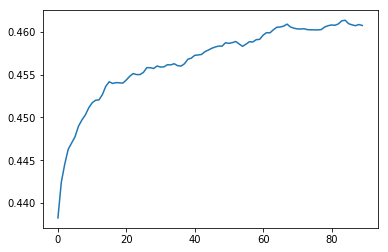

In [65]:
try:
    dcg_callback = CalcValDcg(val_data, 'best_model.keras')
    model.fit_generator(
        generate_batches(train_data),
        steps_per_epoch=train_queries_cnt,
        epochs=100,
        callbacks=[dcg_callback],
        validation_data=generate_batches(val_data),
        validation_steps=val_queries_cnt,
    )
except KeyboardInterrupt:
    dcg_callback.on_train_end(None)

Теперь прочитаем тестовые данные и запишем ответ

In [73]:
best_model = keras.models.load_model('best_model.keras', custom_objects={'loss': loss})

In [74]:
test_data = pd.read_csv('test.tsv', delimiter='\t').values

In [90]:
with open('answer.csv', 'w') as output:
    output.write('docid,quid\n')
    prediction = np.squeeze(best_model.predict(test_data[:, 2:]), axis=1)
    inds = np.lexsort((-prediction, -test_data[:, 1]))
    pd.DataFrame(test_data[inds, :2].astype('int')).to_csv(output, sep=',', index=None, header=None)